Mat文件中的所有键:
__header__
__version__
__globals__
traindata
testdata
traingnd
testgnd
cateTrainTest
anchor_set
trueTrainTest_set

键: traindata
数据类型: <class 'scipy.sparse._coo.coo_matrix'>
稀疏矩阵形状: (11314, 25714)
稀疏矩阵数据类型: float64
非零元素数量: 1006877
稀疏度: 99.65%

键: testdata
数据类型: <class 'scipy.sparse._coo.coo_matrix'>
稀疏矩阵形状: (7532, 25714)
稀疏矩阵数据类型: float64
非零元素数量: 658380
稀疏度: 99.66%

键: traingnd
数据类型: <class 'numpy.ndarray'>
形状: (11314, 1)
数据类型: uint8

键: testgnd
数据类型: <class 'numpy.ndarray'>
形状: (7532, 1)
数据类型: uint8

键: cateTrainTest
数据类型: <class 'numpy.ndarray'>
形状: (11314, 7532)
数据类型: uint8

键: anchor_set
数据类型: <class 'numpy.ndarray'>
形状: (1, 1)
数据类型: [('anchor_100', 'O'), ('anchor_200', 'O'), ('anchor_300', 'O'), ('anchor_400', 'O'), ('anchor_500', 'O')]

键: trueTrainTest_set
数据类型: <class 'numpy.ndarray'>
形状: (1, 1)
数据类型: [('trueTrainTest_100NN', 'O'), ('trueTrainTest_200NN', 'O'), ('trueTrainTest_500NN', 'O')]

训练集标签分布:
标签 1: 480 个样本
标签 2: 584 个样本
标签 3: 591 个样本
标签 4: 590 个样本
标签 5: 578 个

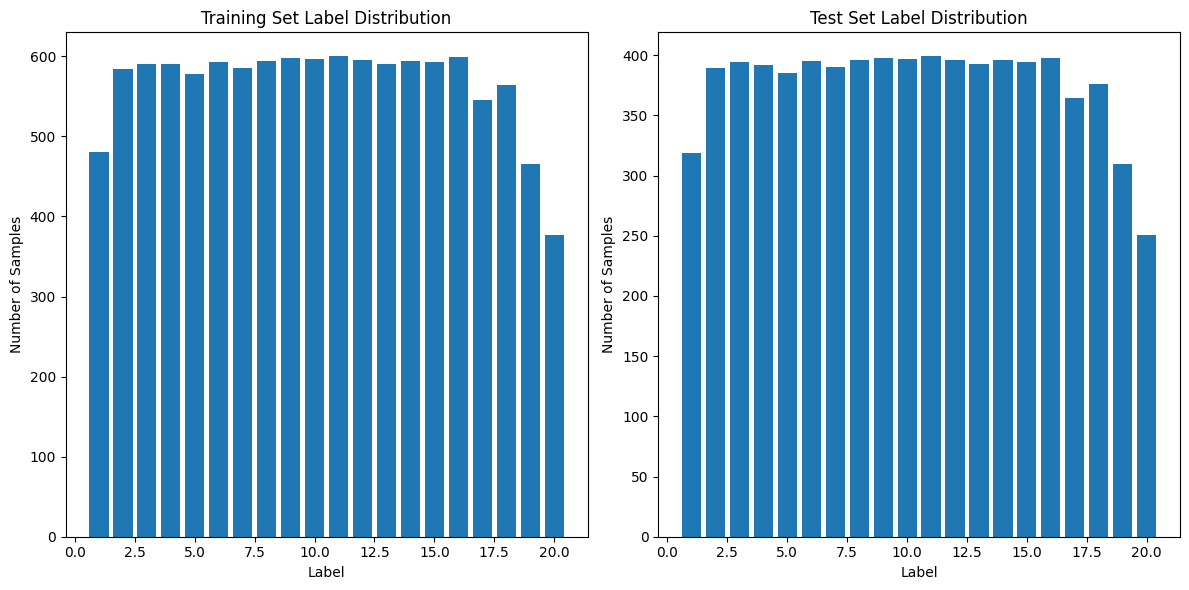

In [2]:
#先对20Newsgroups.mat进行数据分析，确认数据的格式和内容
import numpy as np
from scipy.io import loadmat
from scipy.sparse import issparse
import matplotlib.pyplot as plt

# 加载mat文件
data = loadmat('20Newsgroups.mat')

# 打印所有键
print("Mat文件中的所有键:")
for key in data.keys():
    print(key)

# 分析每个键对应的数据
for key in data.keys():
    if key.startswith('__'):  # 跳过MATLAB的元数据
        continue
    value = data[key]
    print(f"\n键: {key}")
    print(f"数据类型: {type(value)}")
    if isinstance(value, np.ndarray):
        print(f"形状: {value.shape}")
        print(f"数据类型: {value.dtype}")
    elif issparse(value):
        print(f"稀疏矩阵形状: {value.shape}")
        print(f"稀疏矩阵数据类型: {value.dtype}")
        print(f"非零元素数量: {value.nnz}")
        sparsity = 1 - (value.nnz / (value.shape[0] * value.shape[1]))
        print(f"稀疏度: {sparsity * 100:.2f}%")
    else:
        print(f"值: {value}")

# 分析标签分布
if 'traingnd' in data and 'testgnd' in data:
    train_labels = data['traingnd'].flatten()
    test_labels = data['testgnd'].flatten()

    unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
    unique_test_labels, test_counts = np.unique(test_labels, return_counts=True)

    print("\n训练集标签分布:")
    for label, count in zip(unique_train_labels, train_counts):
        print(f"标签 {label}: {count} 个样本")

    print("\n测试集标签分布:")
    for label, count in zip(unique_test_labels, test_counts):
        print(f"标签 {label}: {count} 个样本")

    # 绘制训练集标签分布柱状图
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(unique_train_labels, train_counts)
    plt.title('Training Set Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Number of Samples')

    # 绘制测试集标签分布柱状图
    plt.subplot(1, 2, 2)
    plt.bar(unique_test_labels, test_counts)
    plt.title('Test Set Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Number of Samples')

    plt.tight_layout()
    plt.show()


In [3]:
'''
KNN算法
'''
import torch
from scipy.io import loadmat
from sklearn.metrics import accuracy_score

# 检测设备并打印信息
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前使用设备: {'CUDA: ' + torch.cuda.get_device_name(0) if device.type == 'cuda' else 'CPU'}")

# PyTorch实现PCA类
class TorchPCA:
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        X_centered = X - X.mean(dim=0)
        _, _, V = torch.pca_lowrank(X_centered, q=self.n_components)
        self.components_ = V[:, :self.n_components]
        return self

    def transform(self, X):
        return torch.mm(X, self.components_)

# 加载并处理数据
data = loadmat('20Newsgroups.mat')
traindata = torch.FloatTensor(data['traindata'].toarray()).to(device)
traingnd = torch.LongTensor(data['traingnd'].flatten())
testdata = torch.FloatTensor(data['testdata'].toarray()).to(device)
testgnd = data['testgnd'].flatten()

# PCA降维并计算解释方差比例
num_components = 80
pca = TorchPCA(n_components=num_components).fit(traindata)
traindata_pca = pca.transform(traindata)
testdata_pca = pca.transform(testdata)
explained_variance_ratio = traindata_pca.var(dim=0).sum() / traindata.var(dim=0).sum()
print(f'PCA降维后，前{num_components}个主成分解释的方差比例为: {explained_variance_ratio*100:.2f}%')

# PyTorch实现KNN类
class TorchKNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y.to(X.device)

    def predict(self, X_test):
        X_test_norm = X_test / X_test.norm(dim=1, keepdim=True)
        X_norm = self.X / self.X.norm(dim=1, keepdim=True)
        sims = torch.mm(X_test_norm, X_norm.T)
        _, indices = torch.topk(sims, self.k, largest=True)
        votes = self.y[indices]
        return torch.mode(votes, dim=1).values.cpu().numpy()

class TorchKNNEnsemble:
    def __init__(self, k_list):
        self.models = [TorchKNN(k) for k in k_list]

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def predict(self, X_test):
        preds = torch.stack([torch.from_numpy(model.predict(X_test)) for model in self.models])
        return torch.mode(preds, dim=0).values.numpy()

# 训练、预测并评估
knn = TorchKNNEnsemble(k_list=[1, 3, 5, 7])
knn.fit(traindata_pca, traingnd)
test_pred = knn.predict(testdata_pca)
accuracy = accuracy_score(testgnd, test_pred)
print(f'模型准确率: {accuracy:.6f}')


当前使用设备: CUDA: NVIDIA GeForce RTX 4050 Laptop GPU
PCA降维后，前80个主成分解释的方差比例为: 8.74%
模型准确率: 0.732608


In [4]:
'''
贝叶斯分类器
'''
from scipy.io import loadmat
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfTransformer

# 加载 mat 文件
data = loadmat('20Newsgroups.mat')

# 获取训练数据、测试数据以及对应的标签
train_vectors = data['traindata']
test_vectors = data['testdata']
train_target = data['traingnd'].flatten()
test_target = data['testgnd'].flatten()

# 应用 Tfidf 特征工程
tfidf_transformer = TfidfTransformer()
train_vectors_tfidf = tfidf_transformer.fit_transform(train_vectors)
test_vectors_tfidf = tfidf_transformer.transform(test_vectors)

# 将稀疏矩阵转换为稠密数组（供高斯和伯努利朴素贝叶斯使用）
train_vectors_dense = train_vectors_tfidf.toarray()
test_vectors_dense = test_vectors_tfidf.toarray()

# GaussianNB分类器
gaussian_clf = GaussianNB()
gaussian_clf.fit(train_vectors_dense, train_target)
gaussian_pred = gaussian_clf.predict(test_vectors_dense)

print("\nGaussianNB 评估结果:")
print("F1 分数 (macro):", f1_score(test_target, gaussian_pred, average='macro'))
print("准确率:", accuracy_score(test_target, gaussian_pred))

# BernoulliNB 分类器
bernoulli_clf = BernoulliNB(alpha=0.1)
bernoulli_clf.fit(train_vectors_dense, train_target)
bernoulli_pred = bernoulli_clf.predict(test_vectors_dense)

print("\nBernoulliNB 评估结果:")
print("F1 分数 (macro):", f1_score(test_target, bernoulli_pred, average='macro'))
print("准确率:", accuracy_score(test_target, bernoulli_pred))

# MultinomialNB 分类器
multinomial_clf = MultinomialNB(alpha=0.1)
multinomial_clf.fit(train_vectors, train_target) # MultinomialNB分类器不采用TF-IDF特征化后的数据
multinomial_pred = multinomial_clf.predict(test_vectors)

print("\nMultinomialNB 评估结果:")
print("F1 分数 (macro):", f1_score(test_target, multinomial_pred, average='macro'))
print("准确率:", accuracy_score(test_target, multinomial_pred))


GaussianNB 评估结果:
F1 分数 (macro): 0.7051696627308368
准确率: 0.7116303770578863

BernoulliNB 评估结果:
F1 分数 (macro): 0.7879964314804615
准确率: 0.7903611258629846

MultinomialNB 评估结果:
F1 分数 (macro): 0.8345975507710699
准确率: 0.8425385023898035


In [ ]:
'''
测试更多的分类器，对比分类效果
'''
from scipy.io import loadmat
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score

# 加载 mat 文件
data = loadmat('20Newsgroups.mat')

# 获取训练数据、测试数据以及对应的标签
train_vectors = data['traindata']
test_vectors = data['testdata']
train_target = data['traingnd'].flatten()
test_target = data['testgnd'].flatten()

# 应用 Tfidf 特征工程
tfidf_transformer = TfidfTransformer()
train_vectors_tfidf = tfidf_transformer.fit_transform(train_vectors)
test_vectors_tfidf = tfidf_transformer.transform(test_vectors)

# 初始化分类器
sgd_clf = SGDClassifier()
logreg_clf = LogisticRegression(max_iter=1000)
linear_svc = LinearSVC()
random_forest_clf = RandomForestClassifier()

# 训练和评估模型
def train_and_evaluate(model, train_X, train_y, test_X, test_y, model_name):
    model.fit(train_X, train_y)
    pred = model.predict(test_X)
    print(f"\n{model_name} 评估结果:")
    print("F1 分数 (macro):", f1_score(test_y, pred, average='macro'))
    print("准确率:", accuracy_score(test_y, pred))

# 训练并评估 SGDClassifier
train_and_evaluate(sgd_clf, train_vectors_tfidf, train_target, test_vectors_tfidf, test_target, "SGDClassifier")

# 训练并评估 LogisticRegression
train_and_evaluate(logreg_clf, train_vectors_tfidf, train_target, test_vectors_tfidf, test_target, "LogisticRegression")

# 训练并评估 LinearSVC
train_and_evaluate(linear_svc, train_vectors_tfidf, train_target, test_vectors_tfidf, test_target, "LinearSVC")

# 训练并评估 RandomForestClassifier
train_and_evaluate(random_forest_clf, train_vectors_tfidf, train_target, test_vectors_tfidf, test_target, "RandomForestClassifier")



SGDClassifier 评估结果:
F1 分数 (macro): 0.8571235773772237
准确率: 0.8639139670738184

LogisticRegression 评估结果:
F1 分数 (macro): 0.8520279511942197
准确率: 0.8600637280934679

LinearSVC 评估结果:
F1 分数 (macro): 0.8541354047304155
准确率: 0.8599309612320765

RandomForestClassifier 评估结果:
F1 分数 (macro): 0.7598873393471766
准确率: 0.7729686670207117


In [7]:
'''
单个分类器中，效果最好的是SGDClassifier，准确率达到0.8639;
最后尝试用集成学习的方法进行硬投票，进一步提高精确度
'''
from scipy.io import loadmat
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB

# 加载 mat 文件
data = loadmat('20Newsgroups.mat')

# 获取训练数据、测试数据以及对应的标签
train_vectors = data['traindata']
test_vectors = data['testdata']
train_target = data['traingnd'].flatten()
test_target = data['testgnd'].flatten()

# 应用 Tfidf 特征工程
tfidf_transformer = TfidfTransformer()
train_vectors_tfidf = tfidf_transformer.fit_transform(train_vectors)
test_vectors_tfidf = tfidf_transformer.transform(test_vectors)

# 初始化分类器
multinomial_nb = MultinomialNB()
sgd_clf = SGDClassifier()
logreg_clf = LogisticRegression(max_iter=1000)
linear_svc = LinearSVC()
random_forest_clf = RandomForestClassifier()

# 创建投票分类器
voting_clf = VotingClassifier(
    estimators=[
        ('mnb', multinomial_nb),
        ('sgd', sgd_clf),
        ('logreg', logreg_clf),
        ('linear_svc', linear_svc),
        ('rf', random_forest_clf)
    ],
    voting='hard' 
)

# 训练投票分类器
voting_clf.fit(train_vectors_tfidf, train_target)

# 预测并评估
pred = voting_clf.predict(test_vectors_tfidf)
print("\n投票分类器评估结果:")
print("F1 分数 (macro):", f1_score(test_target, pred, average='macro'))
print("准确率:", accuracy_score(test_target, pred))

'''
准确率最终达到0.866，比所有单个分类器的效果都好，说明集成学习的方法有效
'''


投票分类器评估结果:
F1 分数 (macro): 0.858104877373085
准确率: 0.8661710037174721
